In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-24 19:18:17.953514: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 19:18:18.011090: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 19:18:18.346283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 19:18:19.388783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_name in os.listdir(label_path):
            img_path = os.path.join(label_path, image_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((128, 128))
                img = np.array(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

In [26]:
train_images, train_labels = load_images_from_folder("data/Train")

(-0.5, 127.5, 127.5, -0.5)

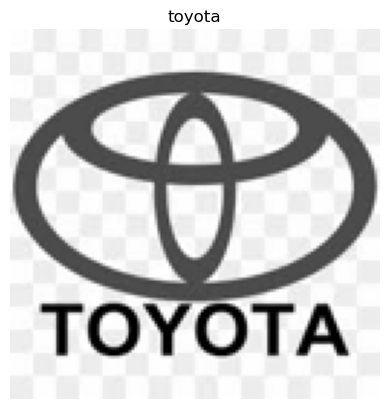

In [33]:
plt.imshow(train_images[500])
plt.title(train_labels[500])
plt.axis('off')